In [1]:
import anndata as an
import scanpy as sc
import scarches as sca
import numpy as np
import gdown

/home/luna/Desktop/in-house/.venv/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/luna/Desktop/in-house/.venv/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/luna/Desktop/in-house/.venv/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/luna/Desktop/in-house/.venv/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/luna/Desktop/in-house/.venv/lib/python3.12/site-packages/anndata/utils.py:429: FutureWar

In [2]:
adata = an.read_h5ad("dataset/tyser.h5ad") 

In [3]:
adata.X = adata.X.astype(np.float32)

In [4]:
url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
output = 'reactome.gmt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c
To: /home/luna/Desktop/in-house/reactome.gmt
100%|██████████| 331k/331k [00:00<00:00, 11.9MB/s]


'reactome.gmt'

In [5]:
sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [6]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [7]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,Source.Name,Characteristics.sampling.site.,Characteristics.inferred.cell.type...authors.labels.,Characteristics.inferred.cell.type...ontology.labels.,cluster_id,sub_cluster,origin,run,sample_name,timepoint,percent.mt
SS.sc7786612,0,259888.990001,6942,SS.sc7786612,rostral,endodermal cell,endodermal cell,Endoderm,DE(P),tyser,tyser,tyser,tyser,1.304482
SS.sc7786605,0,437911.014986,6140,SS.sc7786605,rostral,advanced mesoderm,mesoderm cell,Advanced Mesoderm,Advanced Mesoderm,tyser,tyser,tyser,tyser,1.295160
SS.sc7785737,0,322351.983054,3800,SS.sc7785737,caudal,primitive streak,primitive streak cell,Primitive Streak,Primitive Streak,tyser,tyser,tyser,tyser,1.294179
SS.sc7785398,0,394318.996000,2964,SS.sc7785398,yolk sac,yolk sac mesoderm,mesenchyme of yolk sac,ExE Mesoderm,YS Mesoderm,tyser,tyser,tyser,tyser,1.423720
SS.sc7788091,0,298217.993000,5030,SS.sc7788091,caudal,axial mesoderm,chordamesodermal cell,Axial Mesoderm,Axial Mesoderm,tyser,tyser,tyser,tyser,1.327328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SS.sc7785965,0,226569.027995,6361,SS.sc7785965,caudal,epiblast cell,epiblast cell,Epiblast,Epiblast,tyser,tyser,tyser,tyser,1.675409
SS.sc7788259,0,353921.980998,4647,SS.sc7788259,caudal,primitive streak,primitive streak cell,Primitive Streak,Primitive Streak,tyser,tyser,tyser,tyser,1.615045
SS.sc7786123,0,366998.009999,2822,SS.sc7786123,caudal,primitive streak,primitive streak cell,Primitive Streak,Primitive Streak,tyser,tyser,tyser,tyser,1.602395
SS.sc7786212,0,459601.642974,6110,SS.sc7786212,caudal,epiblast cell,epiblast cell,Epiblast,Epiblast,tyser,tyser,tyser,tyser,1.150624


In [8]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True)

In [9]:
select_terms = adata.varm['I'].sum(0)>12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [10]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [11]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='sample_name',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)



INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1977 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 224
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  224 0 0 1 1977
	with hard mask.
Last Decoder layer: softmax


In [12]:
ALPHA = 0.7

In [13]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stoppinstudyg_kwargs=early_stopping_kwargs,
    use_early_stopstudyping=True,
    monitor_only_val=False,
    seed=2020,
)



Preparing (1069, 1977)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |████████████████████| 100.0%  - epoch_loss: 1325.7578430176 - epoch_recon_loss: 1289.8269653320 - epoch_kl_loss: 71.8617315292 - val_loss: 1338.6719970703 - val_recon_loss: 1303.8923339844 - val_kl_loss: 69.559242248571
Saving best state of network...
Best State was in Epoch 399


In [14]:
MEAN = False

In [15]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)
sc.pp.neighbors(adata, use_rep='X_cvae')
sc.tl.umap(adata)


In [16]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,Source.Name,Characteristics.sampling.site.,Characteristics.inferred.cell.type...authors.labels.,Characteristics.inferred.cell.type...ontology.labels.,cluster_id,sub_cluster,origin,run,sample_name,timepoint,percent.mt
SS.sc7786612,0,259888.990001,6942,SS.sc7786612,rostral,endodermal cell,endodermal cell,Endoderm,DE(P),tyser,tyser,tyser,tyser,1.304482
SS.sc7786605,0,437911.014986,6140,SS.sc7786605,rostral,advanced mesoderm,mesoderm cell,Advanced Mesoderm,Advanced Mesoderm,tyser,tyser,tyser,tyser,1.295160
SS.sc7785737,0,322351.983054,3800,SS.sc7785737,caudal,primitive streak,primitive streak cell,Primitive Streak,Primitive Streak,tyser,tyser,tyser,tyser,1.294179
SS.sc7785398,0,394318.996000,2964,SS.sc7785398,yolk sac,yolk sac mesoderm,mesenchyme of yolk sac,ExE Mesoderm,YS Mesoderm,tyser,tyser,tyser,tyser,1.423720
SS.sc7788091,0,298217.993000,5030,SS.sc7788091,caudal,axial mesoderm,chordamesodermal cell,Axial Mesoderm,Axial Mesoderm,tyser,tyser,tyser,tyser,1.327328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SS.sc7785965,0,226569.027995,6361,SS.sc7785965,caudal,epiblast cell,epiblast cell,Epiblast,Epiblast,tyser,tyser,tyser,tyser,1.675409
SS.sc7788259,0,353921.980998,4647,SS.sc7788259,caudal,primitive streak,primitive streak cell,Primitive Streak,Primitive Streak,tyser,tyser,tyser,tyser,1.615045
SS.sc7786123,0,366998.009999,2822,SS.sc7786123,caudal,primitive streak,primitive streak cell,Primitive Streak,Primitive Streak,tyser,tyser,tyser,tyser,1.602395
SS.sc7786212,0,459601.642974,6110,SS.sc7786212,caudal,epiblast cell,epiblast cell,Epiblast,Epiblast,tyser,tyser,tyser,tyser,1.150624


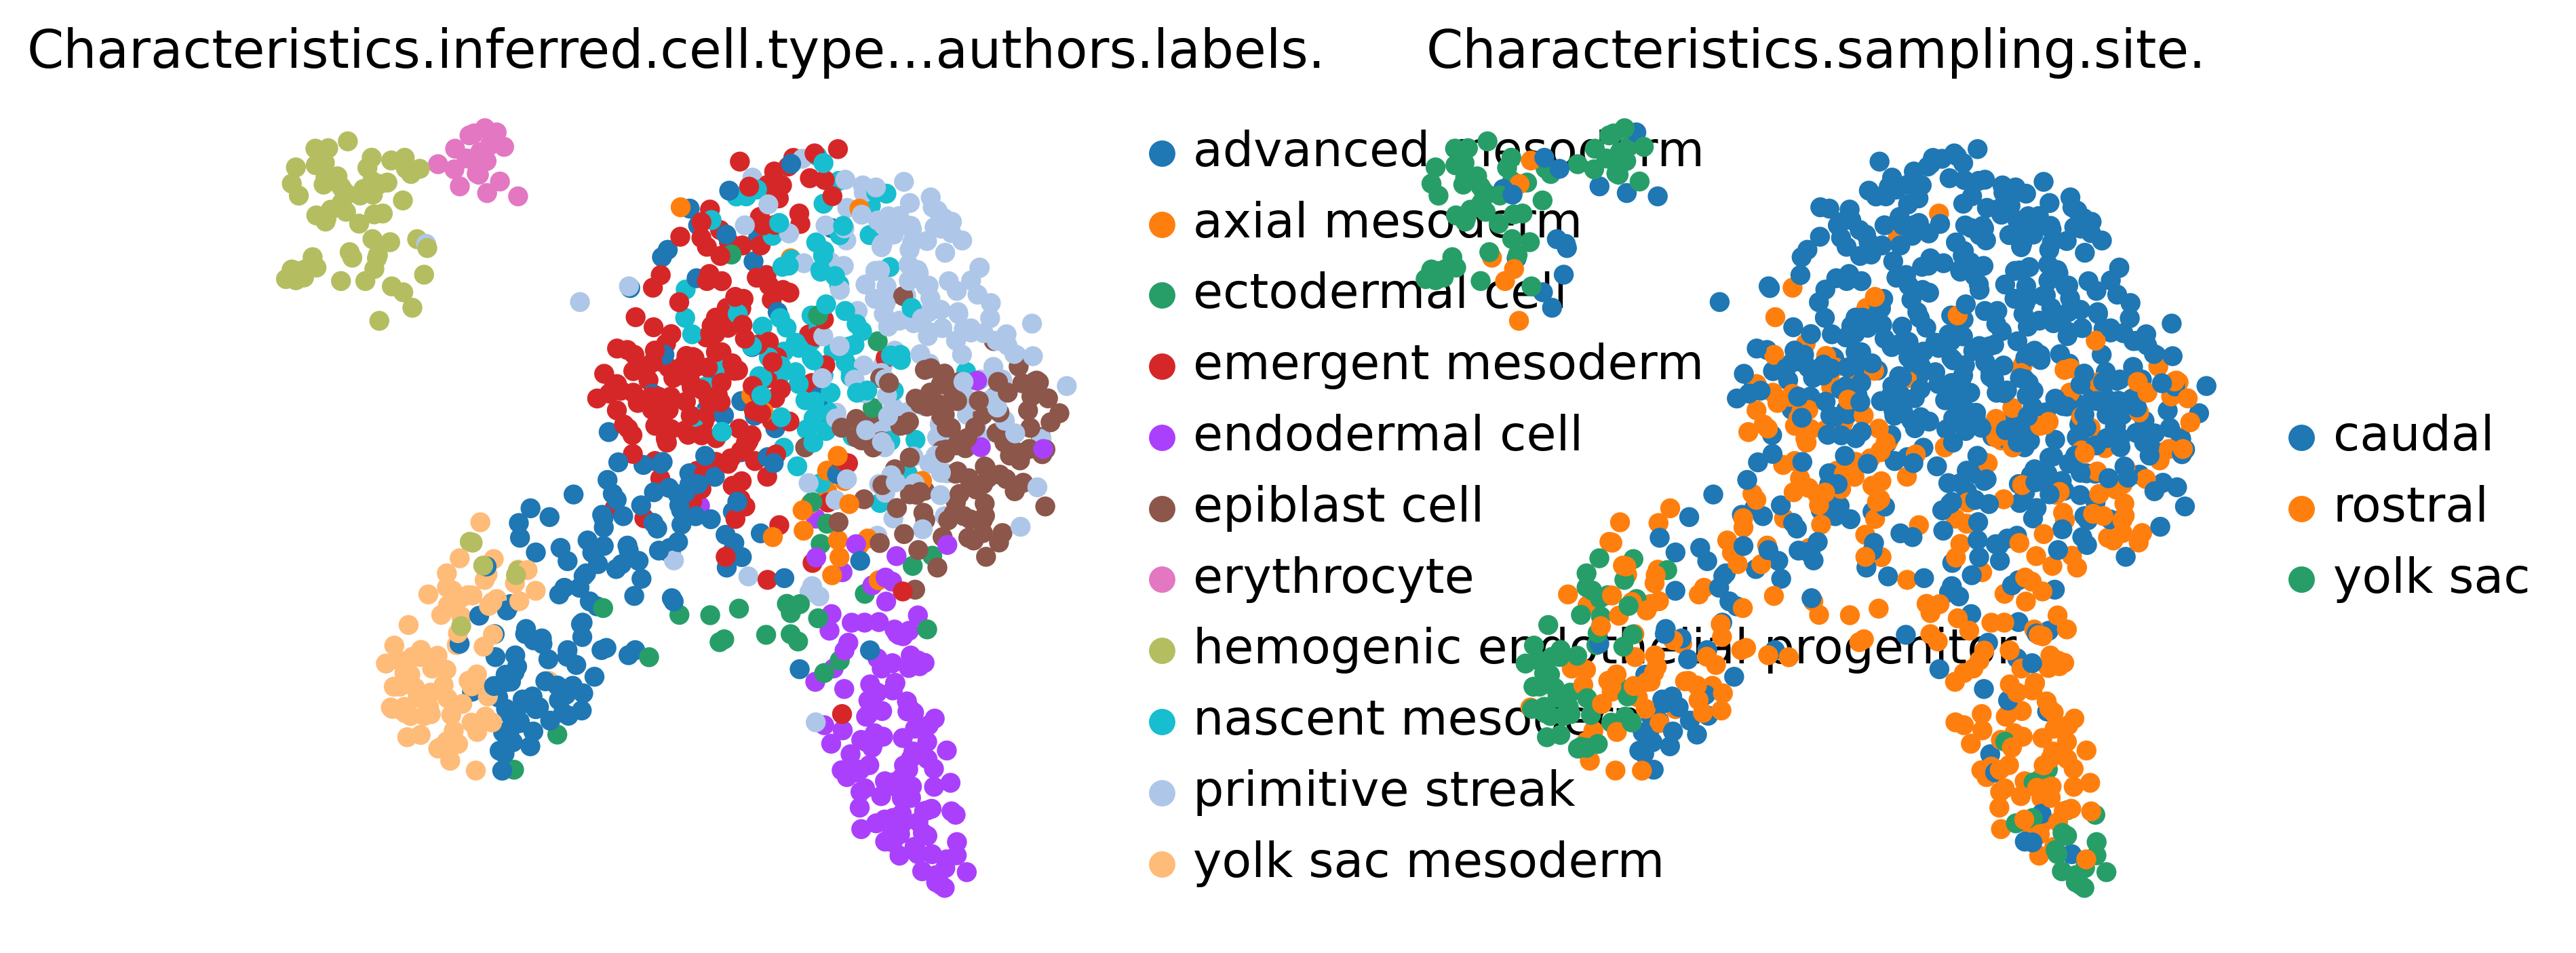

In [17]:
sc.pl.umap(adata, color=['Characteristics.inferred.cell.type...authors.labels.',"Characteristics.sampling.site."], frameon=False)

In [18]:

hips = sc.read('dataset/hiPSC.h5ad')

/home/luna/Desktop/in-house/.venv/lib/python3.12/site-packages/anndata/compat/__init__.py:358: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [19]:
common_var_names = adata.var_names.intersection(hips.var_names)
hips = hips[:, common_var_names].copy()

In [20]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [24]:
q_intr_cvae = sca.models.EXPIMAP.load("hips_tips_querry",adata)

/home/luna/Desktop/in-house/.venv/lib/python3.12/site-packages/scarches/models/base/_base.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load

AnnData object with n_obs × n_vars = 1069 × 1977
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'terms', 'log1p', 'hvg', 'neighbors', 'umap', 'Characteristics.inferred.cell.type...authors.labels._colors', 'Characteristics.sampling.site._colors'
    obsm: 'X_cvae', 'X_umap'
    varm: 'I'
    obsp: 'distances', 'connectivities'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1977 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 224
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  224 0 0 5 1977
	with hard mask.
Last Decoder layer: so

In [ ]:
q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)

Preparing (4694, 1977)
Instantiating dataset
 |██████████----------| 54.2%  - val_loss: 1190.6449584961 - val_recon_loss: 1186.2110595703 - val_kl_loss: 44.3388557434
ADJUSTED LR
 |███████████---------| 58.8%  - val_loss: 1189.2701721191 - val_recon_loss: 1184.8298950195 - val_kl_loss: 44.4028549194
ADJUSTED LR
 |█████████████-------| 65.0%  - val_loss: 1190.8393859863 - val_recon_loss: 1186.3951110840 - val_kl_loss: 44.4426259995
ADJUSTED LR
 |█████████████-------| 66.8%  - val_loss: 1190.1066589355 - val_recon_loss: 1185.6635742188 - val_kl_loss: 44.4310264587
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 245


In [ ]:
q_intr_cvae.save('hips_tips_querry')

In [ ]:
kang = sc.read('kang_tutorial.h5ad')


In [25]:
adata

AnnData object with n_obs × n_vars = 1069 × 1977
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'terms', 'log1p', 'hvg', 'neighbors', 'umap', 'Characteristics.inferred.cell.type...authors.labels._colors', 'Characteristics.sampling.site._colors'
    obsm: 'X_cvae', 'X_umap'
    varm: 'I'
    obsp: 'distances', 'connectivities'

In [36]:
kang_pbmc = sc.AnnData.concatenate(adata, hips, batch_key='batch_join', uns_merge='same')

/tmp/ipykernel_3246/3446286259.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  kang_pbmc = sc.AnnData.concatenate(adata, hips, batch_key='batch_join', uns_merge='same')


In [37]:
kang_pbmc

AnnData object with n_obs × n_vars = 5763 × 1841
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt', 'percent.dissoc', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.22', 'batch_join'
    var: 'features', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0'
    obsm: 'X_umap'

In [40]:
sc.pp.neighbors(kang_pbmc)
sc.tl.umap(kang_pbmc)

In [48]:
kang_pbmc.obs

,orig.ident,nCount_RNA,nFeature_RNA,Source.Name,Characteristics.sampling.site.,Characteristics.inferred.cell.type...authors.labels.,Characteristics.inferred.cell.type...ontology.labels.,cluster_id,sub_cluster,origin,run,sample_name,timepoint,percent.mt,percent.dissoc,RNA_snn_res.0.3,seurat_clusters,RNA_snn_res.0.22,batch_join
SS.sc7786612-0,0,259888.990001,6942,SS.sc7786612,rostral,endodermal cell,endodermal cell,Endoderm,DE(P),tyser,tyser,tyser,tyser,1.304482,NaN,NaN,NaN,NaN,0
SS.sc7786605-0,0,437911.014986,6140,SS.sc7786605,rostral,advanced mesoderm,mesoderm cell,Advanced Mesoderm,Advanced Mesoderm,tyser,tyser,tyser,tyser,1.295160,NaN,NaN,NaN,NaN,0
SS.sc7785737-0,0,322351.983054,3800,SS.sc7785737,caudal,primitive streak,primitive streak cell,Primitive Streak,Primitive Streak,tyser,tyser,tyser,tyser,1.294179,NaN,NaN,NaN,NaN,0
SS.sc7785398-0,0,394318.996000,2964,SS.sc7785398,yolk sac,yolk sac mesoderm,mesenchyme of yolk sac,ExE Mesoderm,YS Mesoderm,tyser,tyser,tyser,tyser,1.423720,NaN,NaN,NaN,NaN,0
SS.sc7788091-0,0,298217.993000,5030,SS.sc7788091,caudal,axial mesoderm,chordamesodermal cell,Axial Mesoderm,Axial Mesoderm,tyser,tyser,tyser,tyser,1.327328,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
batch_1_sample_120H_TTTACTGCATCCGCGA-1-1,SeuratProject,14013.000000,4629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120h,iPSC_72_1,NaN,4.767002,0.017398,3,2,2.0,1
batch_1_sample_120H_TTTCACATCAGCCCAG-1-1,SeuratProject,21173.000000,5140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120h,iPSC_72_1,NaN,4.127899,0.014142,5,4,4.0,1
batch_1_sample_120H_TTTCAGTAGTACAGAT-1-1,SeuratProject,22107.000000,5437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120h,iPSC_72_1,NaN,2.035554,0.013721,3,2,2.0,1
batch_1_sample_120H_TTTGATCAGCTCCATA-1-1,SeuratProject,12806.000000,4127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120h,iPSC_72_1,NaN,3.428081,0.015297,3,2,2.0,1


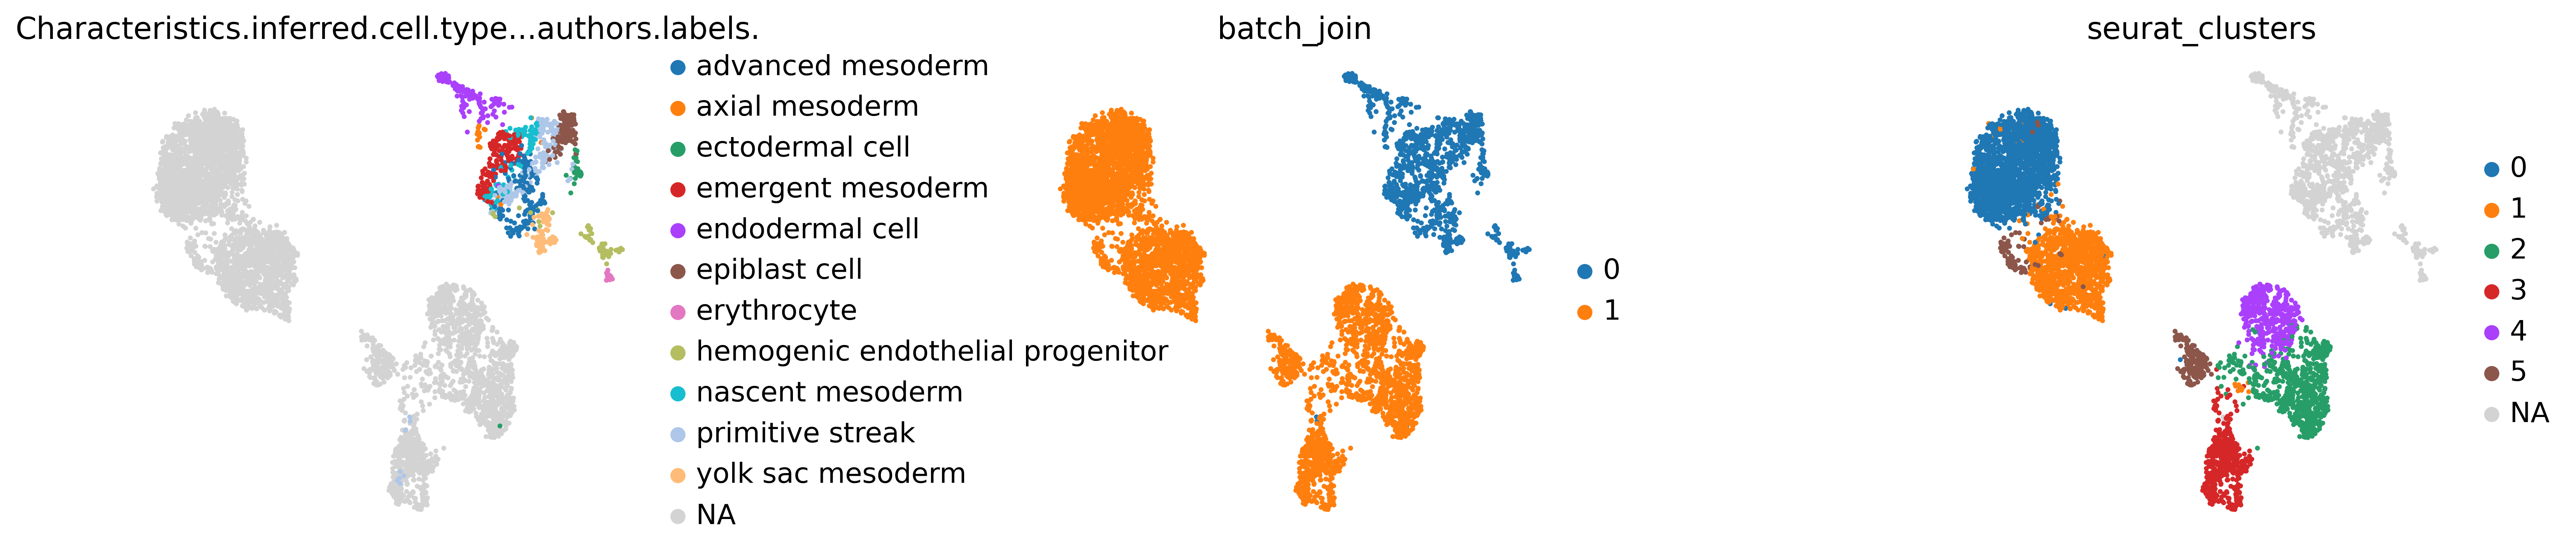

In [ ]:
sc.pl.umap(kang_pbmc, color=['Characteristics.inferred.cell.type...authors.labels.',"seurat_clusters"], frameon=False, wspace=0.6)